# Hyper-parameter tuning

In [1]:
%load_ext autoreload
%autoreload 2

!python --version

Python 3.7.6


In [2]:
import sys
sys.path.append('..')

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


def plot_grid_search_cv_results(clf, distributions, **kwargs):    
    heatmap=kwargs.get('heatmap', False)
    figsize=kwargs.get('figsize', (20, 5))
    
    df_gridsearch = pd.DataFrame(clf.cv_results_)
    
    params_values = df_gridsearch.params
    raw_params_names = list(distributions.keys())
    params_names = [f'param_{param}' for param in raw_params_names]
    max_scores = df_gridsearch.groupby(params_names).max()

    if len(params_names) == 1 and heatmap == True:
        return
    
    if heatmap == False:
        fig, axs = plt.subplots(nrows=len(raw_params_names), figsize=(figsize[0], figsize[1] * len(raw_params_names)))
        
        for index, param_name in enumerate(raw_params_names):
            mean_test_scores = list(max_scores.mean_test_score)
            param_values = [param_value[param_name] for param_value in params_values]

            df = pd.DataFrame({ param_name: param_values, 'mean_test_score': mean_test_scores })

            if type(axs) is np.ndarray:
                sns.barplot(data=df, x=param_name, y='mean_test_score', ax=axs[index])
            else:
                sns.barplot(data=df, x=param_name, y='mean_test_score')
    else:
        max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
        
        fig, axs = plt.subplots(figsize=figsize)
        
        sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',ax=axs);
        
    return clf.best_params_, clf.best_score_

## Classification

In [78]:
from src.evaluation import custom_classification_report

### Load the dataset

In [90]:
from src.dataset import DatasetForClassification

dataset = DatasetForClassification('../data/fifa_processed_for_cls.csv', ['Position (4)', 'Position (13)'])

### Classification of "Position (4)"

In [91]:
X_train, X_test, y_train, y_test = dataset.get_data('Position (4)')

labels = dataset.get_labels('Position (4)')

Do oversampling based on the results from 09_SMOTE.ipynb. We use the method which performed the best.

In [51]:
from imblearn.over_sampling import SVMSMOTE

sm = SVMSMOTE(
    k_neighbors=20,
    m_neighbors=40,
    n_jobs=-1,
    out_step=0.5,
    random_state=42,
    sampling_strategy='auto',
    svm_estimator=None)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Select features based on the results from 10_feature_selection.ipynb. We use the method which performed the best.

In [52]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

sel = GenericUnivariateSelect(chi2, 'k_best', param=42)
sel.fit(X_train, y_train)

selected_columns = []

for selected, column in zip(sel.get_support(), X_train_res.columns):
    if selected:
        selected_columns.append(column)

In [53]:
X_train_res_sel = X_train_res[selected_columns]
X_test_sel = X_test[selected_columns]

#### Training

In [13]:
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

Firstly, we will train model with the oversampled data and selected features and compare it with baseline (without oversampling and feature selction).

attack
precision: 0.85
recall: 0.7961432506887053
f1-score: 0.8221906116642959
support: 726


defense
precision: 0.9524632670700086
recall: 0.929957805907173
f1-score: 0.9410760034158839
support: 1185


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8347763347763347
recall: 0.881859756097561
f1-score: 0.8576723498888064
support: 1312


accuracy: 0.89366391184573


macro avg
precision: 0.9093099004615859
recall: 0.9019902031733598
f1-score: 0.9052347412422466
support: 3630


weighted avg
precision: 0.8947646068056506
recall: 0.89366391184573
f1-score: 0.8937607634077728
support: 3630


F1
micro: 0.89366391184573
macro: 0.9052347412422466


CPU times: user 1.55 s, sys: 615 ms, total: 2.17 s
Wall time: 5min 25s


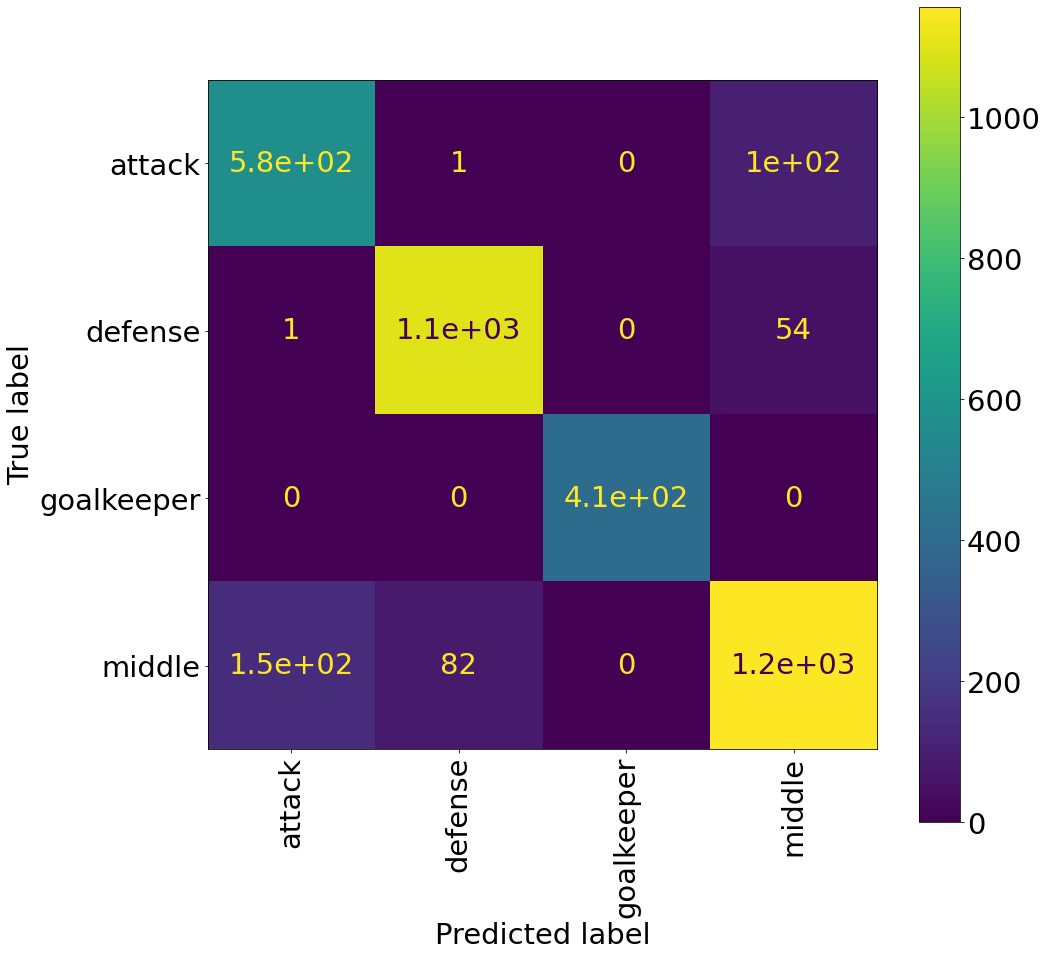

In [54]:
%%time

clf_lr = LogisticRegression(max_iter=10000, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_ada = AdaBoostClassifier(n_estimators=100, base_estimator=RandomForestClassifier(random_state=42), random_state=42)

estimators = [
    ('lr', clf_lr),
    ('rf', clf_rf),
    ('gb', clf_gb),
    ('ada', clf_ada)
]

clf = StackingClassifier(estimators=estimators, cv=5, n_jobs=-1, final_estimator=LogisticRegression(max_iter=10000, n_jobs=-1))

clf.fit(X_train_res_sel, y_train_res)

custom_classification_report(clf, labels, X_test_sel, y_test, figsize=(15, 15))

attack
precision: 0.8117647058823529
recall: 0.8466257668711656
f1-score: 0.8288288288288288
support: 652


defense
precision: 0.9394987035436474
recall: 0.9403114186851211
f1-score: 0.9399048854301774
support: 1156


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8795093795093795
recall: 0.8614840989399293
f1-score: 0.8704034273473759
support: 1415


accuracy: 0.8994490358126722


macro avg
precision: 0.907693197233845
recall: 0.912105321124054
f1-score: 0.9097842854015955
support: 3630


weighted avg
precision: 0.8999550582747995
recall: 0.8994490358126722
f1-score: 0.8995998054132833
support: 3630


F1
micro: 0.8994490358126722
macro: 0.9097842854015955


CPU times: user 960 ms, sys: 738 ms, total: 1.7 s
Wall time: 2min 17s


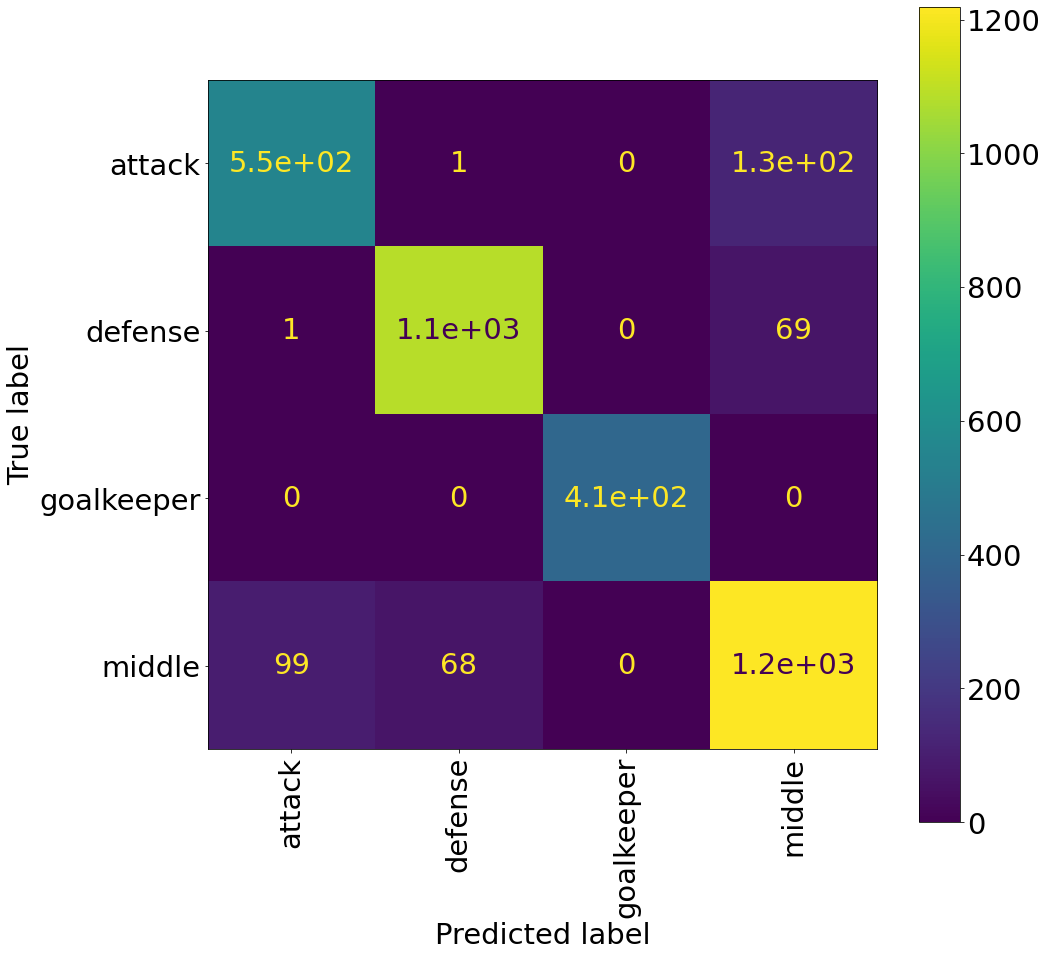

In [56]:
%%time

clf_lr = LogisticRegression(max_iter=10000, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_ada = AdaBoostClassifier(n_estimators=100, base_estimator=RandomForestClassifier(random_state=42), random_state=42)

estimators = [
    ('lr', clf_lr),
    ('rf', clf_rf),
    ('gb', clf_gb),
    ('ada', clf_ada)
]

clf = StackingClassifier(estimators=estimators, cv=5, n_jobs=-1, final_estimator=LogisticRegression(max_iter=10000, n_jobs=-1))

clf.fit(X_train, y_train)

custom_classification_report(clf, labels, X_test, y_test, figsize=(15, 15))

The model without oversampling and feature selection, is better.

Hyper-parameter tunning on this model is possible, but it would take too much time (since one execution is ~5 minutes). We will try to hyper-tune GradientBoostingClassifier instead.

Firstly, hyper-tune the number of estimators.

In [16]:
gbr = GradientBoostingClassifier(random_state=42)

distributions = {
    "n_estimators": range(50, 600, 10)
}

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="f1_micro", verbose=2, return_train_score=True)

search_1_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 114.4min finished


({'n_estimators': 180}, 0.8817940071494388)

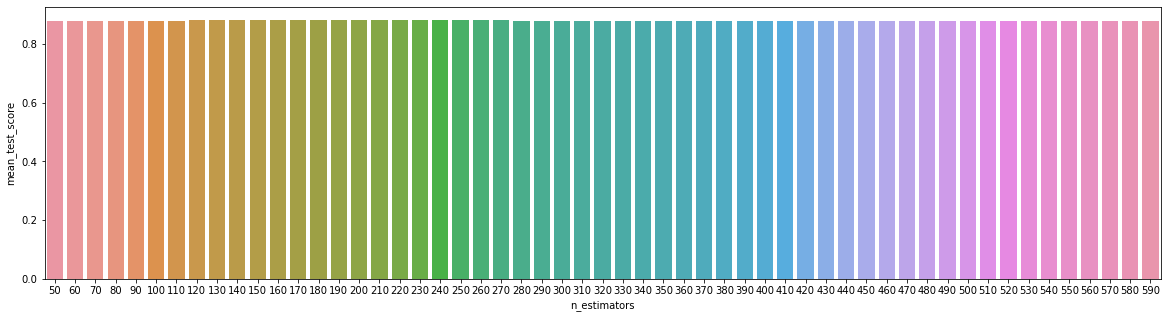

In [25]:
plot_grid_search_cv_results(search_1_clf, distributions)

We will use `n_estimators=180` estimators, since the more estimators we used, there was not a significant improvement and training time increased.

We will do `k=3` fold cross-validation, since we are trying large number of parameters.

In [30]:
gbr = GradientBoostingClassifier(n_estimators=180, random_state=42)

distributions = {
    "max_depth": range(1, 7, 2),
    "min_samples_split": range(2, 45, 5),
    "min_samples_leaf": range(1, 10, 2)
}

clf = GridSearchCV(gbr, distributions, cv=3, n_jobs=-1, scoring="f1_micro", verbose=2, return_train_score=True)

search_2_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 79.9min finished


({'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 37},
 0.8836536474478199)

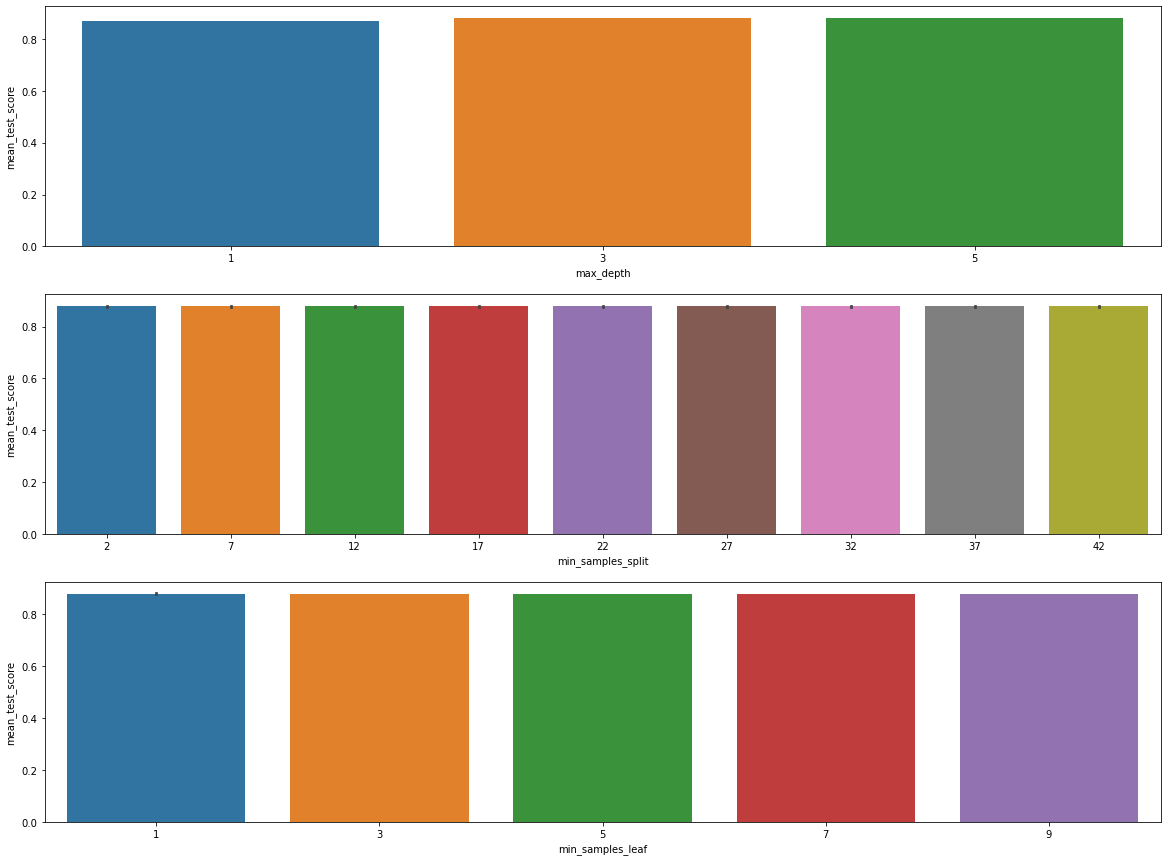

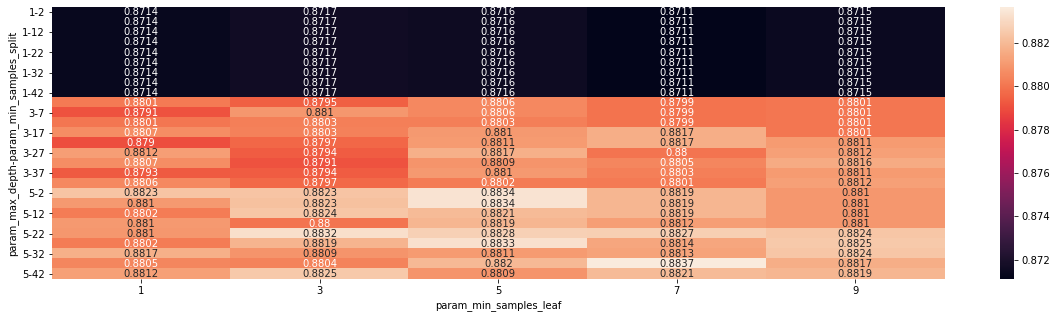

In [31]:
plot_grid_search_cv_results(search_2_clf, distributions)
plot_grid_search_cv_results(search_2_clf, distributions, heatmap=True)

#### Evaluate

With oversampling and feature selection.

attack
precision: 0.8294117647058824
recall: 0.8
f1-score: 0.8144404332129964
support: 705


defense
precision: 0.9446845289541919
recall: 0.9192598822539949
f1-score: 0.9317988064791134
support: 1189


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8311688311688312
recall: 0.8668171557562077
f1-score: 0.8486187845303867
support: 1329


accuracy: 0.8859504132231405


macro avg
precision: 0.9013162812072264
recall: 0.8965192595025506
f1-score: 0.8987145060556241
support: 3630


weighted avg
precision: 0.8869390015613108
recall: 0.8859504132231405
f1-score: 0.8861993528814635
support: 3630


F1
micro: 0.8859504132231405
macro: 0.8987145060556241




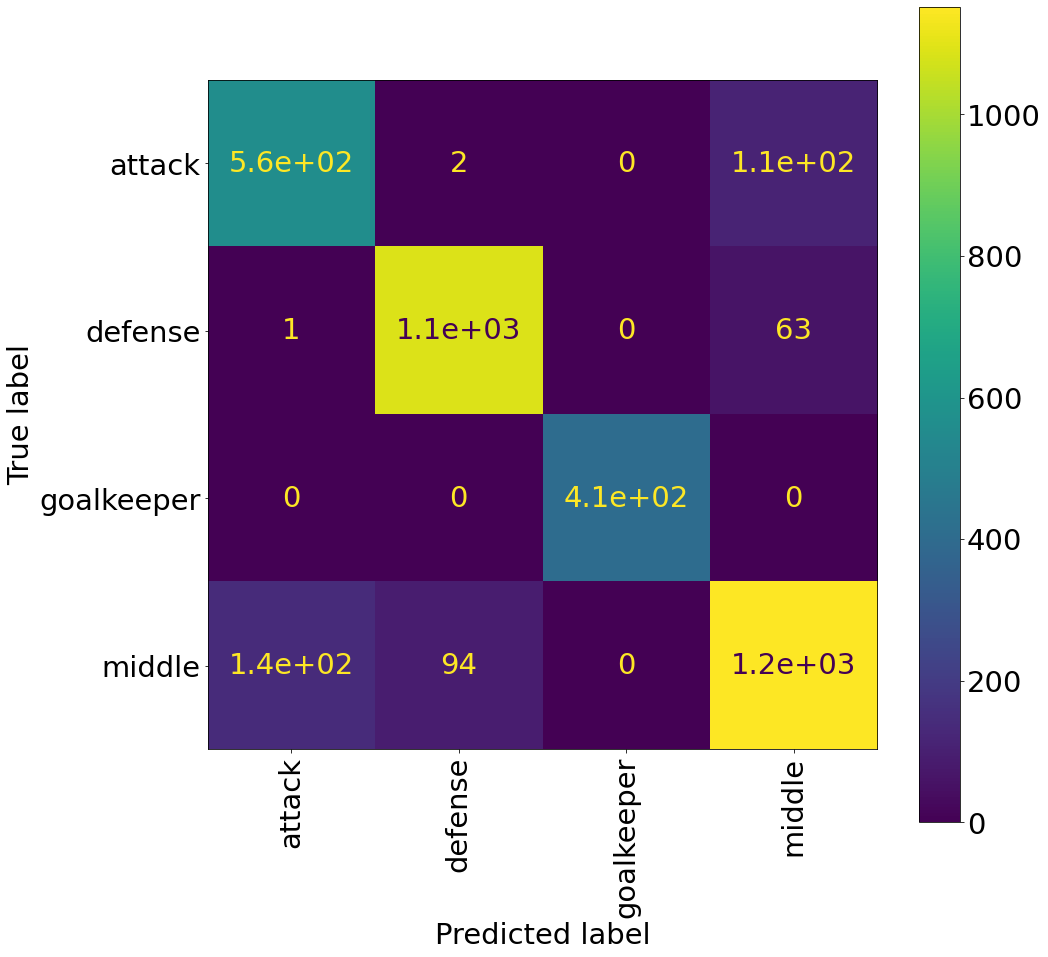

In [55]:
gbr = GradientBoostingClassifier(n_estimators=180, max_depth=5, min_samples_leaf=7, min_samples_split=37, random_state=42)

gbr.fit(X_train_res_sel, y_train_res)

custom_classification_report(gbr, labels, X_test_sel, y_test, figsize=(15, 15))

Without oversampling and feature selection.

attack
precision: 0.7970588235294118
recall: 0.8429237947122862
f1-score: 0.819349962207105
support: 643


defense
precision: 0.9446845289541919
recall: 0.9333902647309992
f1-score: 0.9390034364261168
support: 1171


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8737373737373737
recall: 0.8594748048261178
f1-score: 0.8665474060822898
support: 1409


accuracy: 0.8961432506887053


macro avg
precision: 0.9038701815552443
recall: 0.9089472160673507
f1-score: 0.906225201178878
support: 3630


weighted avg
precision: 0.897198448080091
recall: 0.8961432506887053
f1-score: 0.896523510998374
support: 3630


F1
micro: 0.8961432506887053
macro: 0.906225201178878




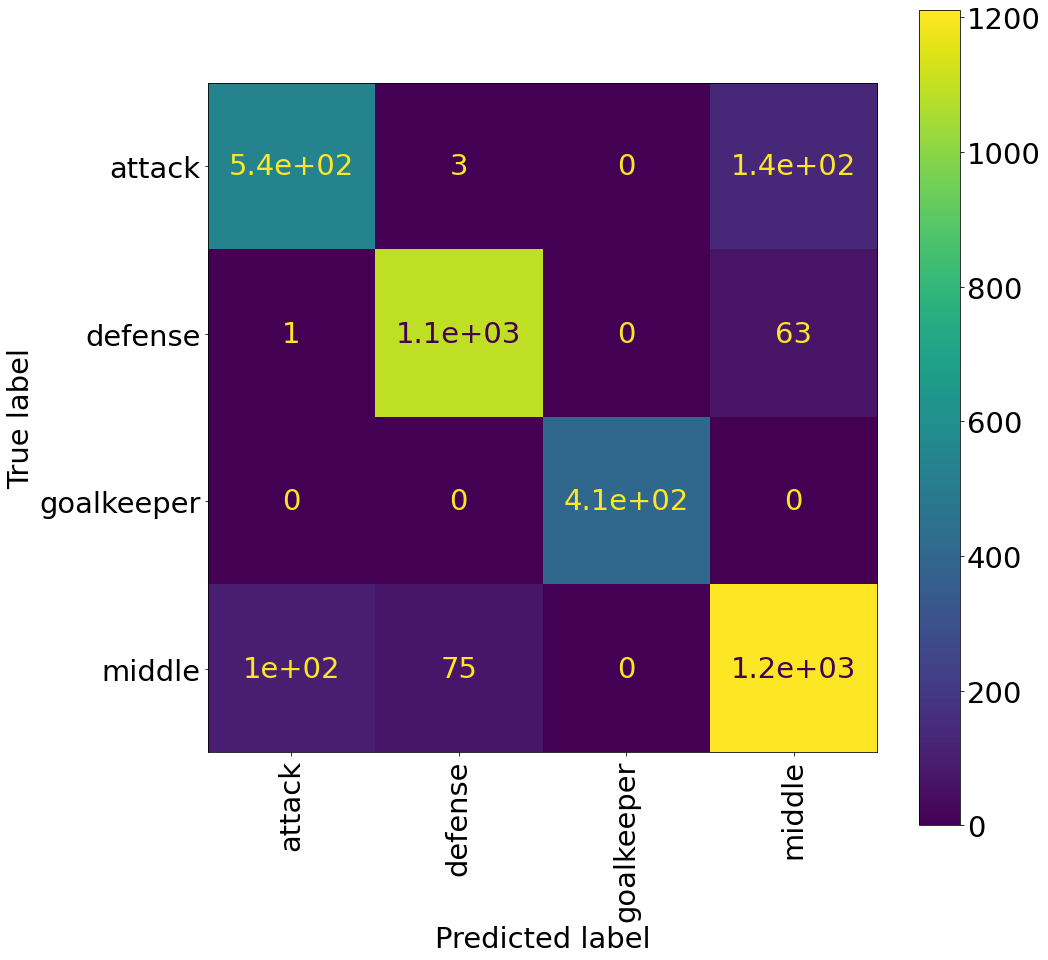

In [83]:
gbr = GradientBoostingClassifier(n_estimators=180, max_depth=5, min_samples_leaf=7, min_samples_split=37, random_state=42)

gbr.fit(X_train, y_train)

custom_classification_report(gbr, labels, X_test, y_test, figsize=(15, 15))

Use features based on the feature selection from `10_feature_selection.ipynb`.

attack
precision: 0.7764705882352941
recall: 0.8237129485179407
f1-score: 0.7993943981831945
support: 641


defense
precision: 0.9170267934312878
recall: 0.9122957867583835
f1-score: 0.9146551724137931
support: 1163


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8477633477633477
recall: 0.8280479210711769
f1-score: 0.8377896613190731
support: 1419


accuracy: 0.8735537190082645


macro avg
precision: 0.8853151823574823
recall: 0.8910141640868753
f1-score: 0.8879598079790152
support: 3630


weighted avg
precision: 0.8744341593100831
recall: 0.8735537190082645
f1-score: 0.8738234997698163
support: 3630


F1
micro: 0.8735537190082645
macro: 0.8879598079790152




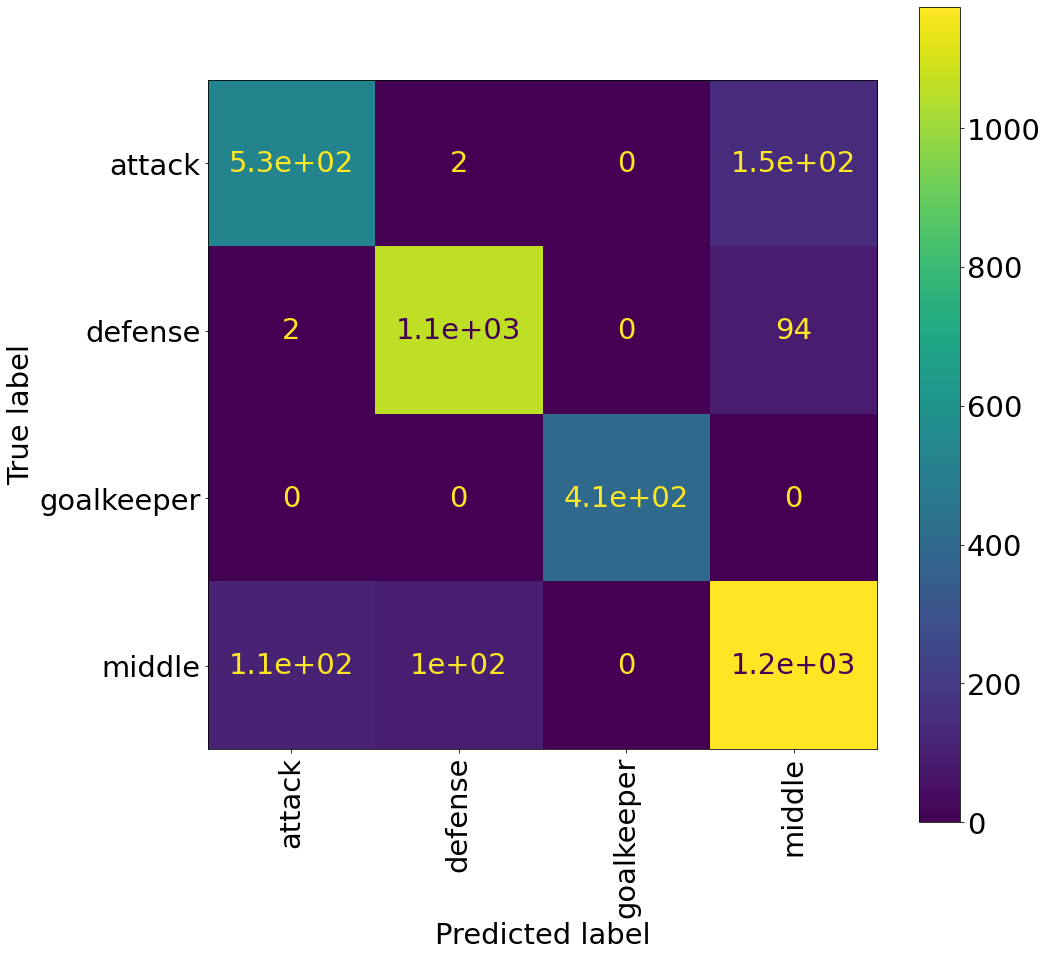

In [92]:
features = ['Crossing', 'Finishing', 'HeadingAccuracy', 'Volleys', 'LongPassing', 'LongShots', 'Interceptions', 'Vision', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKReflexes']

print(f'Used features - {len(features)}')

gbr = GradientBoostingClassifier(n_estimators=180, max_depth=5, min_samples_leaf=7, min_samples_split=37, random_state=42)

gbr.fit(X_train[features], y_train)

custom_classification_report(gbr, labels, X_test[features], y_test, figsize=(15, 15))

The baseline model.

attack
precision: 0.7955882352941176
recall: 0.8426791277258567
f1-score: 0.8184568835098335
support: 642


defense
precision: 0.9369057908383751
recall: 0.9328743545611016
f1-score: 0.9348857266062959
support: 1162


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8737373737373737
recall: 0.8534178999295279
f1-score: 0.8634581105169341
support: 1419


accuracy: 0.8933884297520661


macro avg
precision: 0.9015578499674666
recall: 0.9072428455541215
f1-score: 0.9042001801582658
support: 3630


weighted avg
precision: 0.8942935287455506
recall: 0.8933884297520661
f1-score: 0.8936731659375643
support: 3630


F1
micro: 0.8933884297520661
macro: 0.9042001801582658




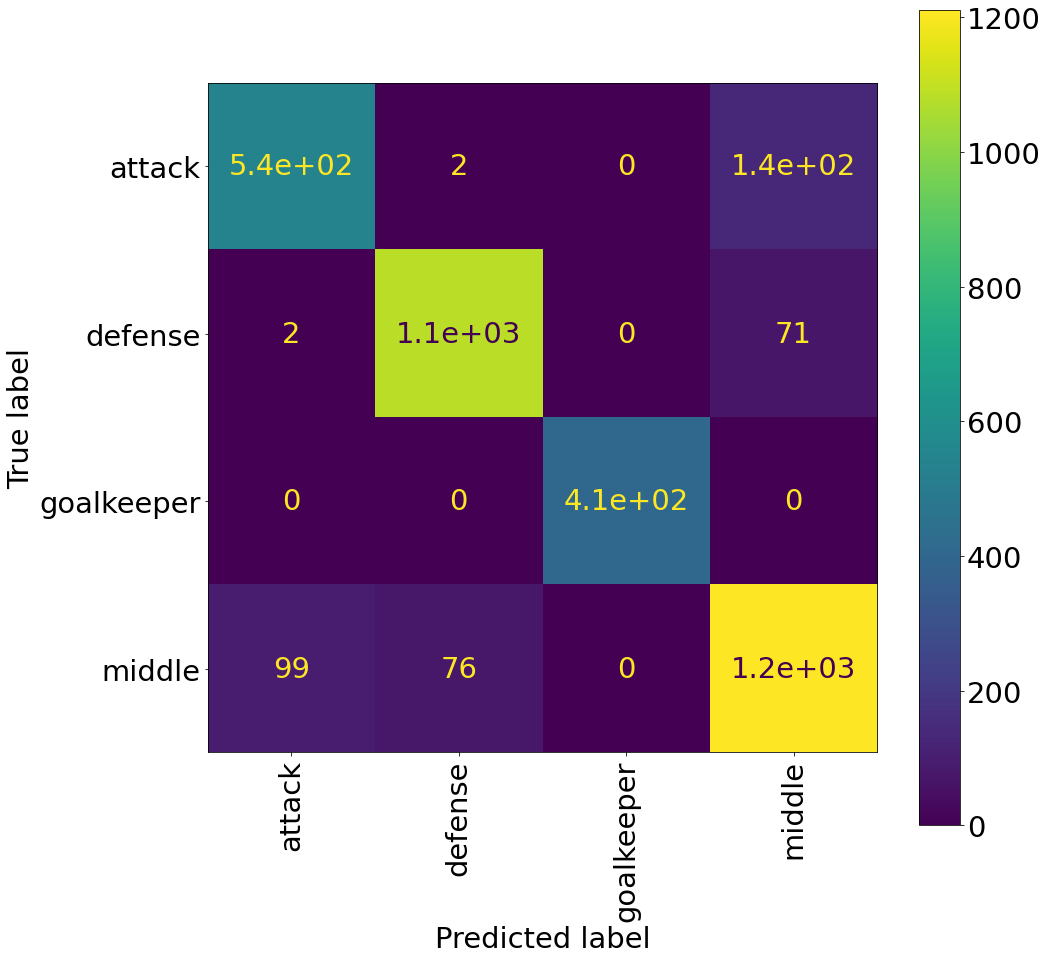

In [84]:
gbr = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbr.fit(X_train, y_train)

custom_classification_report(gbr, labels, X_test, y_test, figsize=(15, 15))

### Classification of "Position (13)"

We won't do a hyper-parameter tuning for this, since it would take too long.

In [85]:
X_train, X_test, y_train, y_test = dataset.get_data('Position (13)')

labels = dataset.get_labels('Position (13)')

Oversampling.

In [40]:
from imblearn.over_sampling import SVMSMOTE

sm = SVMSMOTE(
    k_neighbors=20,
    m_neighbors=40,
    n_jobs=-1,
    out_step=0.5,
    random_state=42,
    sampling_strategy='auto',
    svm_estimator=None)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Feature selection.

In [41]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

sel = GenericUnivariateSelect(chi2, 'k_best', param=42)
sel.fit(X_train, y_train)

selected_columns = []

for selected, column in zip(sel.get_support(), X_train_res.columns):
    if selected:
        selected_columns.append(column)

In [42]:
X_train_res_sel = X_train_res[selected_columns]
X_test_sel = X_test[selected_columns]

#### Training

attacking midfielder
precision: 0.42777777777777776
recall: 0.4375
f1-score: 0.43258426966292135
support: 176


central attack
precision: 0.9024943310657596
recall: 0.7119856887298748
f1-score: 0.796
support: 559


central defense
precision: 0.7938931297709924
recall: 0.6910299003322259
f1-score: 0.7388987566607459
support: 301


deffensive midfielder
precision: 0.49454545454545457
recall: 0.5506072874493927
f1-score: 0.5210727969348659
support: 247


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


left attack
precision: 0.06837606837606838
recall: 0.125
f1-score: 0.08839779005524863
support: 64


left defense
precision: 0.8051470588235294
recall: 0.8202247191011236
f1-score: 0.8126159554730984
support: 267


left midfielder
precision: 0.3593073593073593
recall: 0.32936507936507936
f1-score: 0.3436853002070393
support: 252


middle
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 3


midfielder
precision: 0.6681127982646421
recall: 0.5934489402697495
f1-score: 0.628

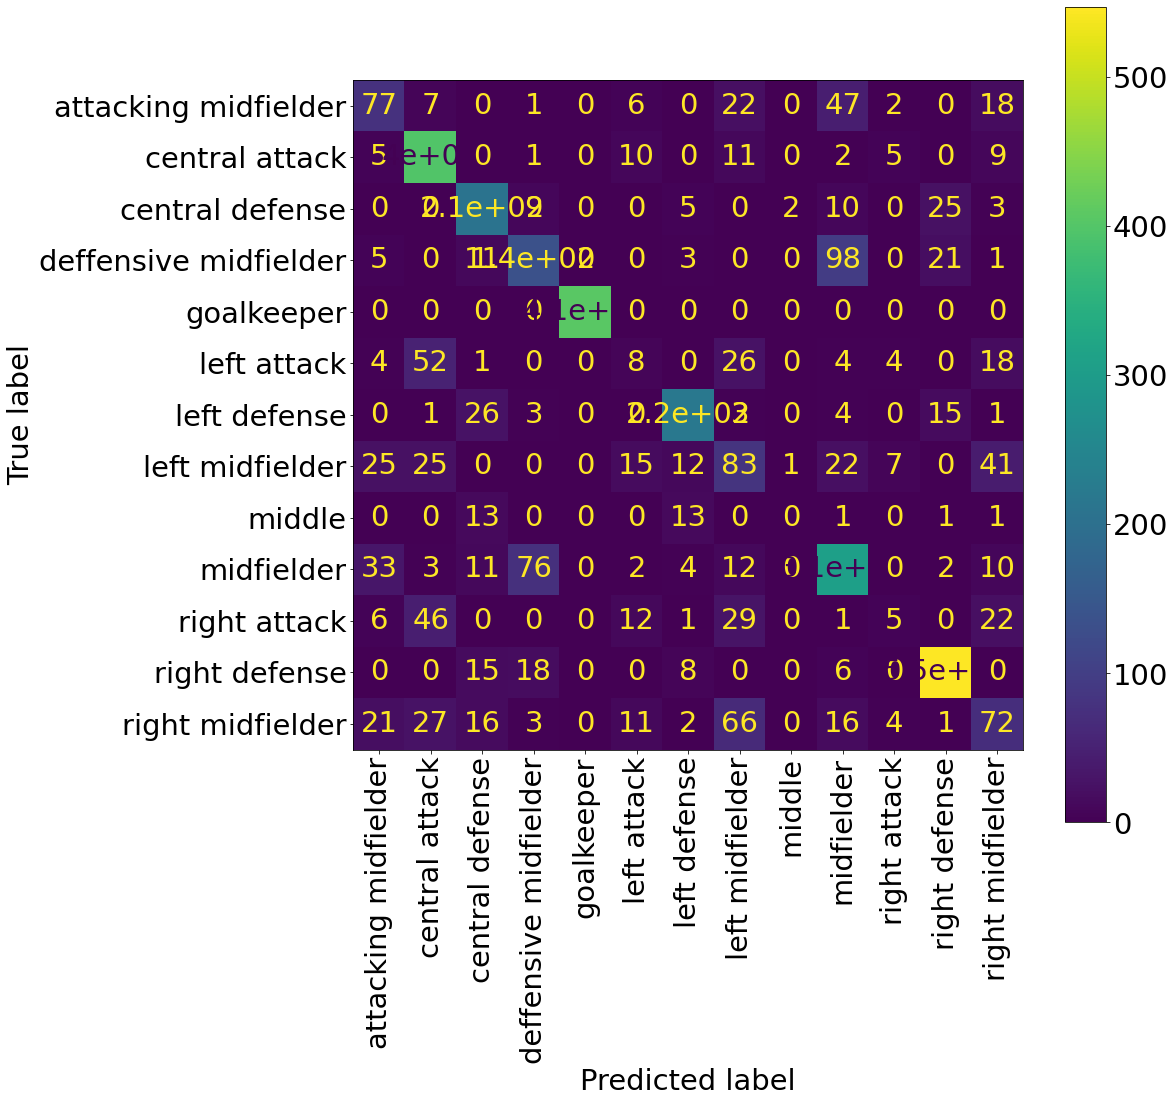

In [47]:
%%time

clf_lr = LogisticRegression(max_iter=10000, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_ada = AdaBoostClassifier(n_estimators=100, base_estimator=RandomForestClassifier(random_state=42), random_state=42)

estimators = [
    ('lr', clf_lr),
    ('rf', clf_rf),
    ('gb', clf_gb),
    ('ada', clf_ada)
]

clf = StackingClassifier(estimators=estimators, cv=5, n_jobs=-1, final_estimator=LogisticRegression(max_iter=10000, n_jobs=-1))

clf.fit(X_train_res_sel, y_train_res)

custom_classification_report(clf, labels, X_test_sel, y_test, figsize=(15, 15))

However, we will try to use the hyper-parameters from the previous task (Position (4)).

attacking midfielder
precision: 0.4722222222222222
recall: 0.4857142857142857
f1-score: 0.47887323943661975
support: 175


central attack
precision: 0.9002267573696145
recall: 0.7218181818181818
f1-score: 0.8012108980827448
support: 550


central defense
precision: 0.7786259541984732
recall: 0.6962457337883959
f1-score: 0.7351351351351352
support: 293


deffensive midfielder
precision: 0.56
recall: 0.5945945945945946
f1-score: 0.5767790262172284
support: 259


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


left attack
precision: 0.09401709401709402
recall: 0.2558139534883721
f1-score: 0.1375
support: 43


left defense
precision: 0.8014705882352942
recall: 0.8352490421455939
f1-score: 0.8180112570356473
support: 261


left midfielder
precision: 0.33766233766233766
recall: 0.3291139240506329
f1-score: 0.3333333333333333
support: 237


middle
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 6


midfielder
precision: 0.7114967462039046
recall: 0.6200378071833649
f1-sco

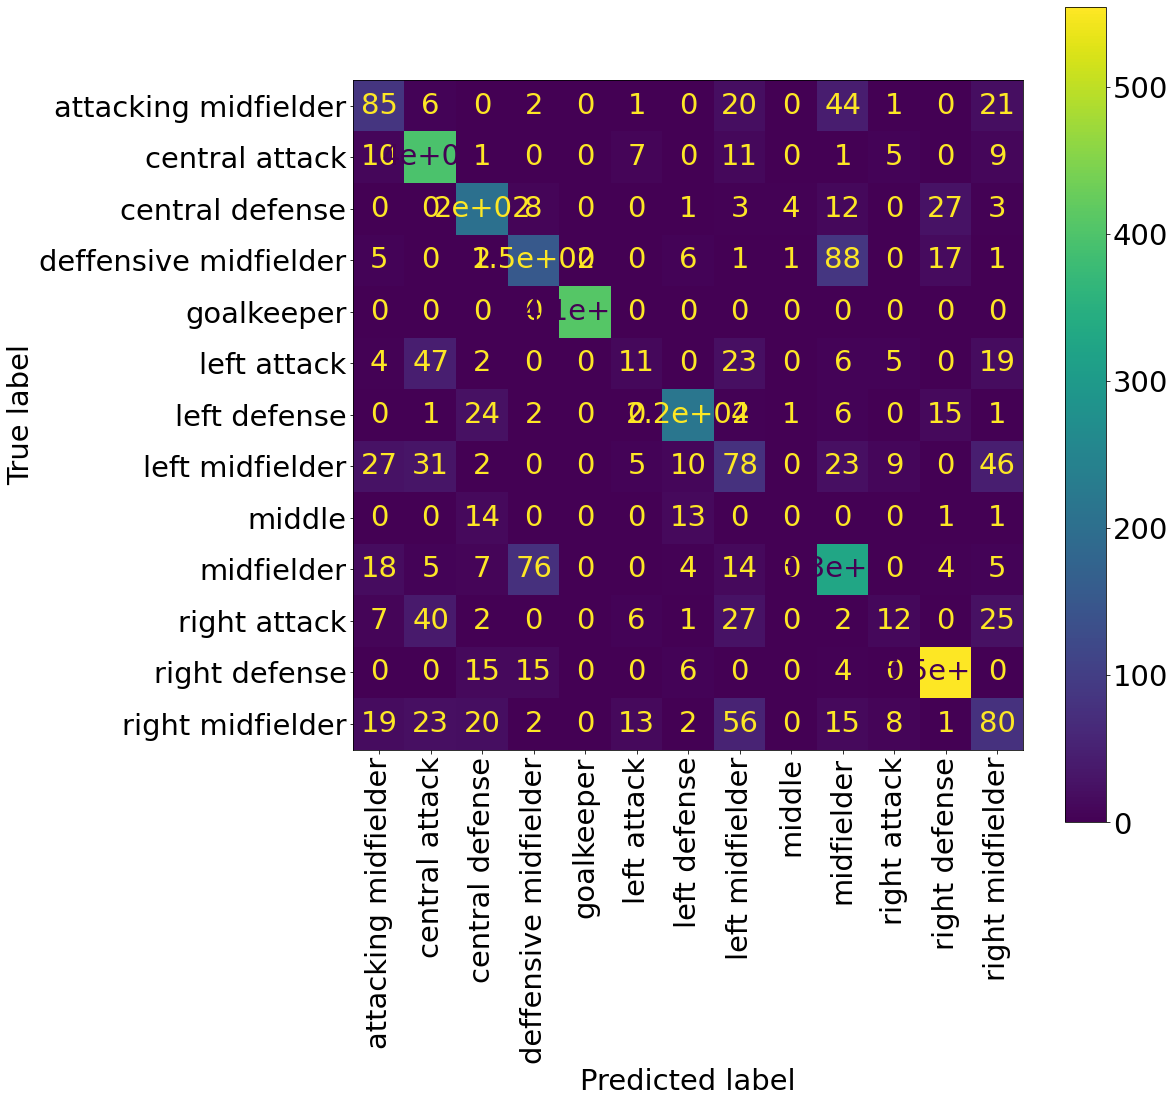

In [86]:
gbr = GradientBoostingClassifier(n_estimators=180, max_depth=5, min_samples_leaf=7, min_samples_split=37, random_state=42)

gbr.fit(X_train, y_train)

custom_classification_report(gbr, labels, X_test, y_test, figsize=(15, 15))

attacking midfielder
precision: 0.4777777777777778
recall: 0.5029239766081871
f1-score: 0.4900284900284901
support: 171


central attack
precision: 0.9251700680272109
recall: 0.7183098591549296
f1-score: 0.8087215064420218
support: 568


central defense
precision: 0.7824427480916031
recall: 0.6765676567656765
f1-score: 0.7256637168141593
support: 303


deffensive midfielder
precision: 0.5709090909090909
recall: 0.5946969696969697
f1-score: 0.5825602968460112
support: 264


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


left attack
precision: 0.05982905982905983
recall: 0.2413793103448276
f1-score: 0.09589041095890412
support: 29


left defense
precision: 0.8051470588235294
recall: 0.8171641791044776
f1-score: 0.8111111111111112
support: 268


left midfielder
precision: 0.30735930735930733
recall: 0.35678391959798994
f1-score: 0.33023255813953484
support: 199


middle
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 6


midfielder
precision: 0.7223427331887202
recal

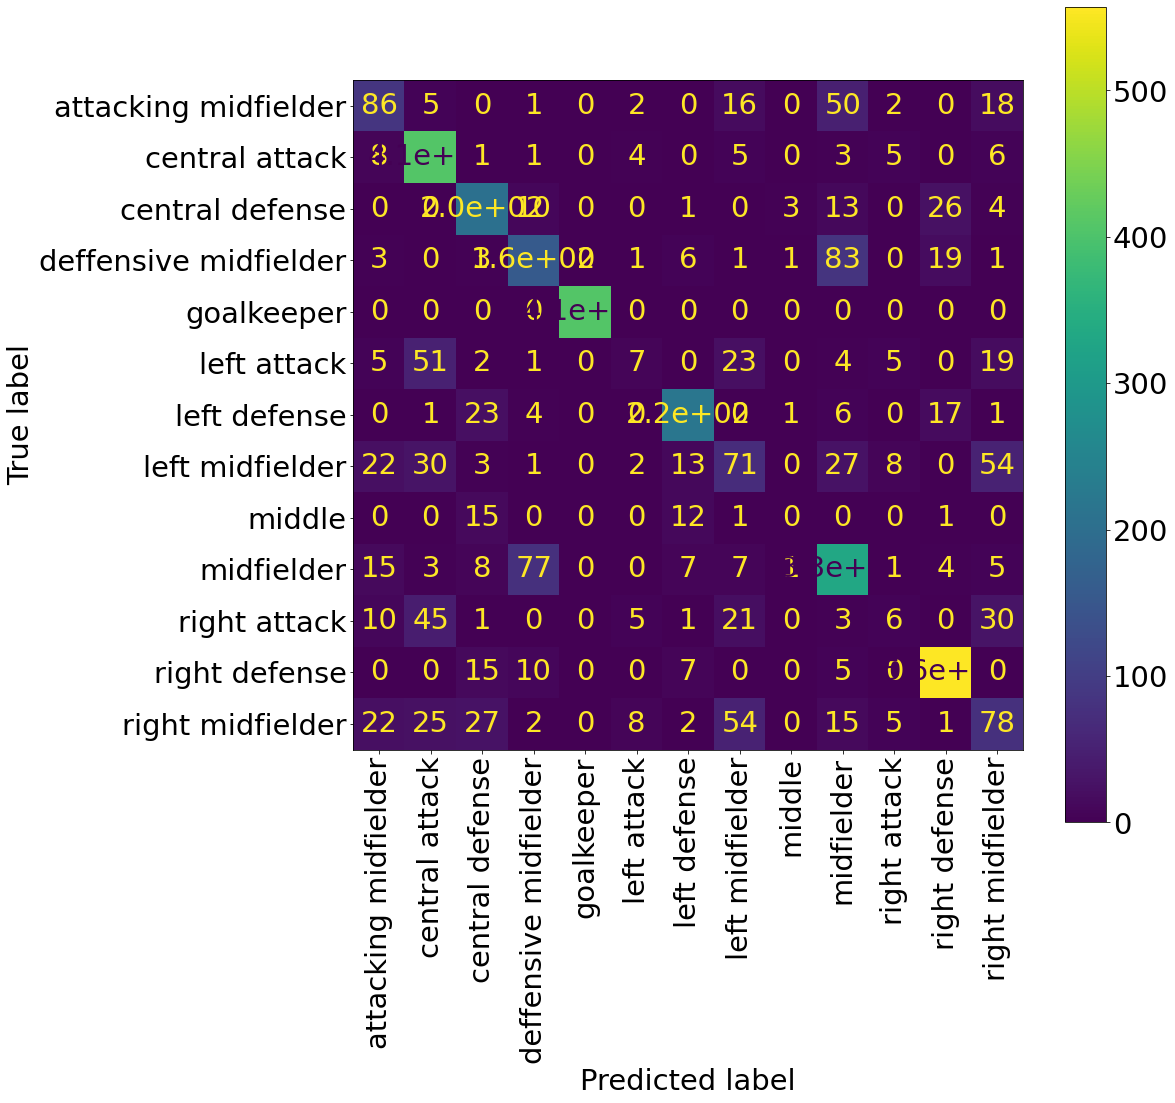

In [87]:
gbr = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbr.fit(X_train, y_train)

custom_classification_report(gbr, labels, X_test, y_test, figsize=(15, 15))

### Conclusion

For classification to --

__4__ positions, the best model achieved    

F1 micro: 0.6798898071625344

F1 macro: 0.5128542989147941
    
    
and to __13__ positions, the best model achieved    

F1 micro: 0.6798898071625344

F1 macro: 0.5128542989147941

## Regression

In [59]:
from src.evaluation import custom_regression_report

### Load the dataset

In [96]:
from src.dataset import DatasetForRegression

dataset = DatasetForRegression('../data/fifa_processed_for_reg.csv', ['Value'])

In [97]:
X_train, X_test, y_train, y_test = dataset.get_data('Value')

We will compare all features with the selected features from `10_feature_selection.ipynb` ('Age', 'Overall', 'Potential').

### Train

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

We will use GradientBoostingRegressor since it was the best regressor.

We will do hyper-parameter tunning in several steps, we will start with the most important parameters (those) which make a significant impact on a model. We followed this [tutorial](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

Firstly we will try different number of estimators.

In [81]:
%%time

gbr = GradientBoostingRegressor(random_state=42)
distributions = { "n_estimators": range(50, 600, 10) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_1_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 38.6min finished


CPU times: user 1min 2s, sys: 1.16 s, total: 1min 3s
Wall time: 39min 33s


({'n_estimators': 590}, -633697.8569601651)

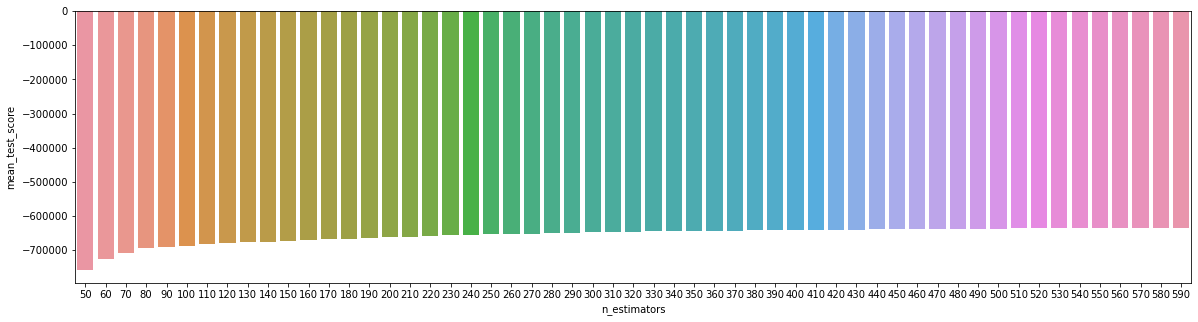

In [95]:
plot_grid_search_cv_results(search_1_clf, distributions)

Since the decrease from 200 was really minor but the training duration increased significantly, we will use 200 estimators.

We will hyper-tune max_depth & min_samples_split.

In [99]:
%%time

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)

distributions = { "max_depth": range(5, 16, 2), "min_samples_split": range(200, 1001, 200) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_2_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 35.6min finished


CPU times: user 22.3 s, sys: 262 ms, total: 22.6 s
Wall time: 35min 59s


({'max_depth': 5, 'min_samples_split': 200}, -761604.3735874773)

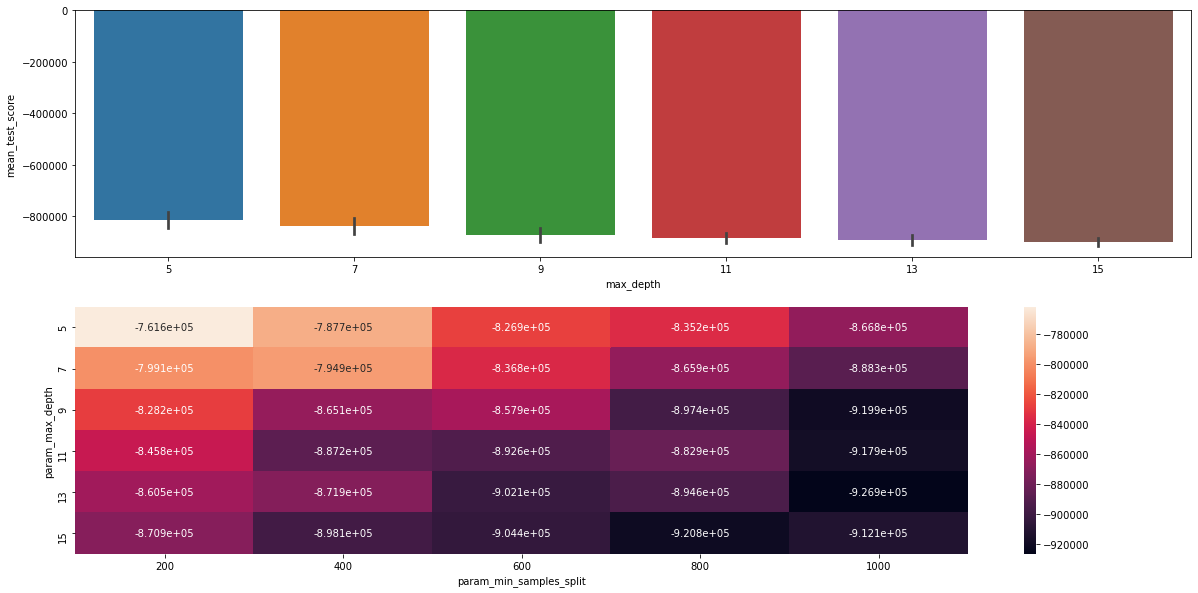

In [108]:
plot_grid_search_cv_results(search_2_clf, distributions)
plot_grid_search_cv_results(search_2_clf, distributions, heatmap=True)

There is not an improvement in the model...

In [125]:
%%time

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)

distributions = { "max_depth": range(3, 10, 2), "min_samples_split": range(2, 100, 5) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_2a_clf = clf.fit(X_train, y_train)

(20, 5)


({'max_depth': 3, 'min_samples_split': 12}, -661813.3966771839)

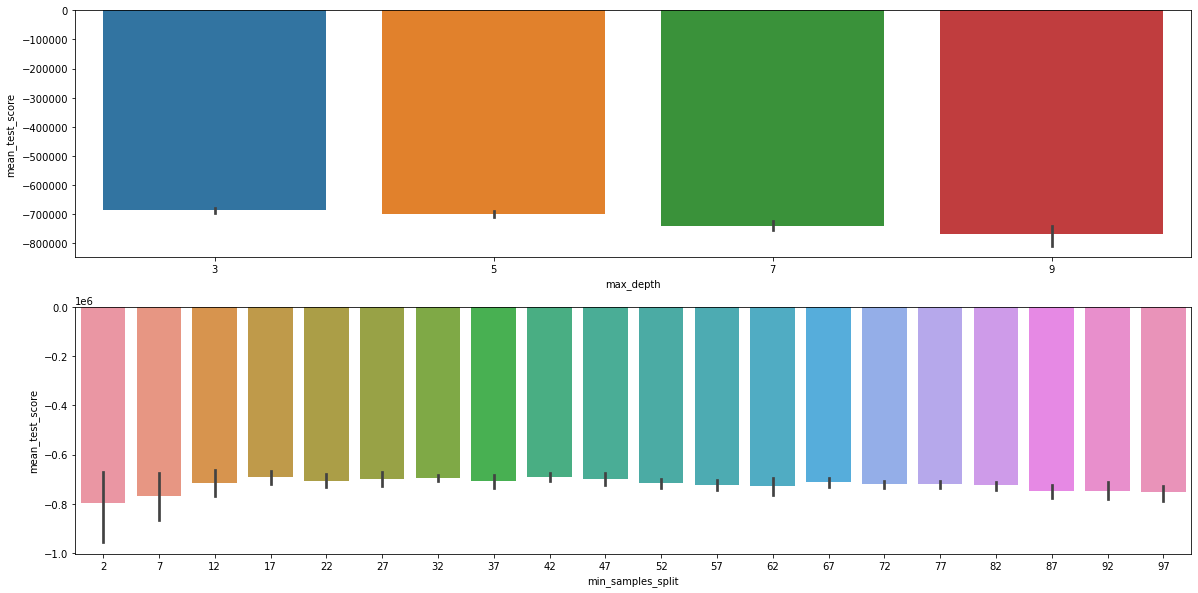

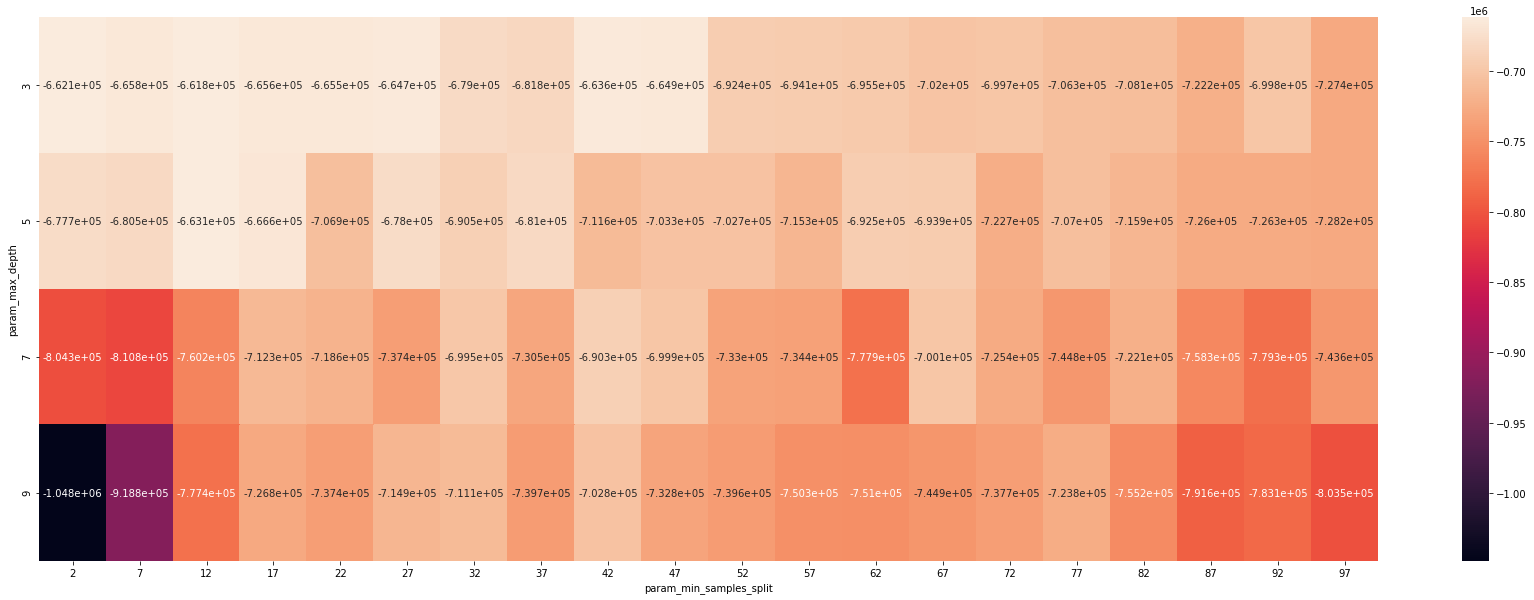

In [121]:
plot_grid_search_cv_results(search_2a_clf, distributions)
plot_grid_search_cv_results(search_2a_clf, distributions, heatmap=True, figsize=(30, 10))

We will use `max_depth=3` and `min_samples_split=12`.

We will hyper-tune min_samples_split & min_samples_leaf.

In [155]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, min_samples_split=13, random_state=42)

distributions = { "min_samples_split": range(2, 50, 8), "min_samples_leaf": range(1, 20, 4) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_3_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.9min finished


({'min_samples_leaf': 5, 'min_samples_split': 42}, -620656.5336109585)

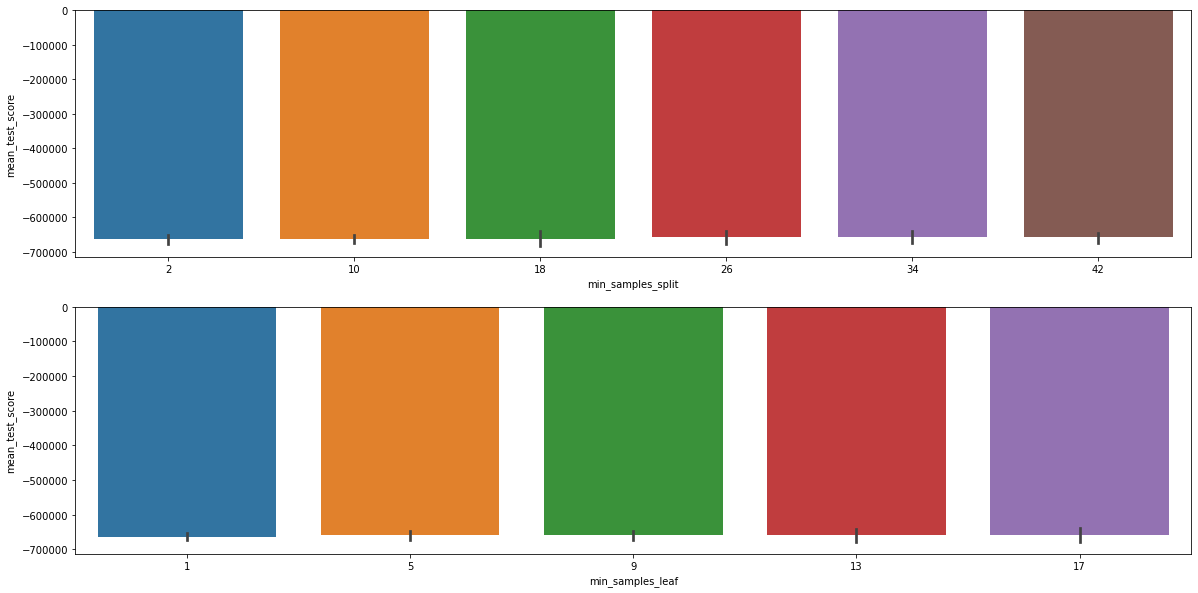

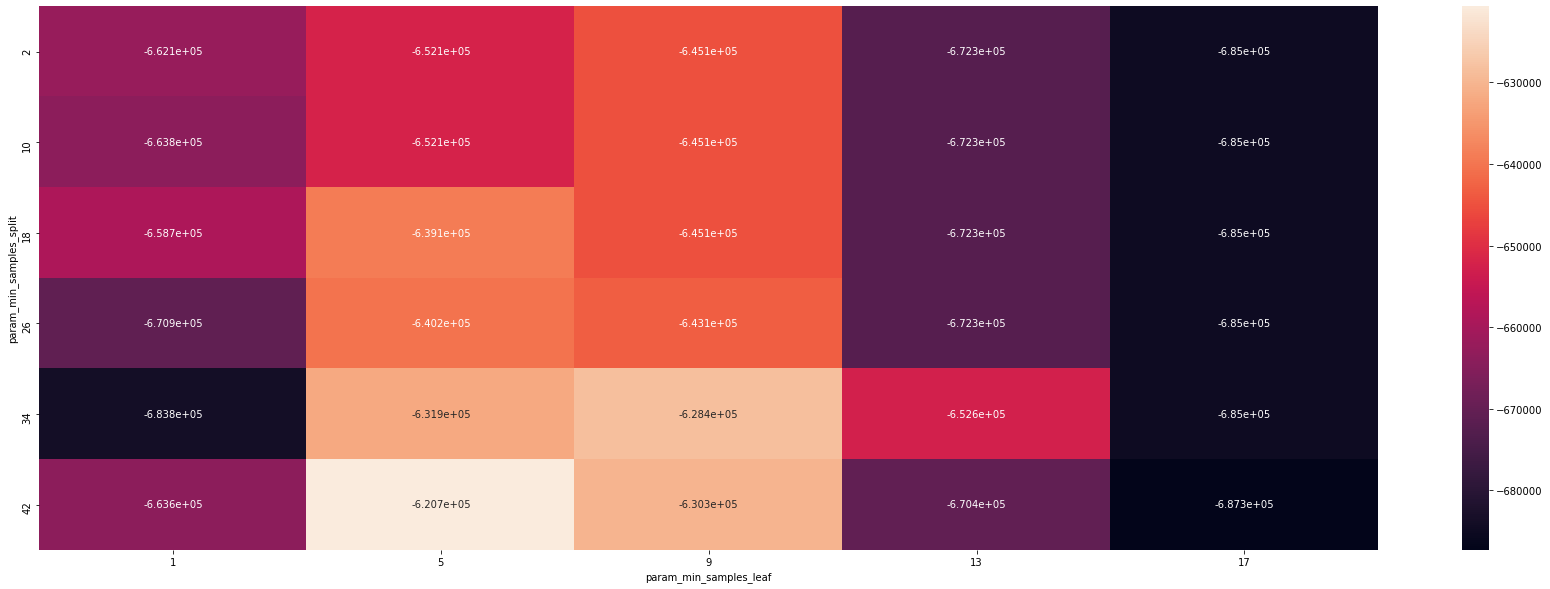

In [156]:
plot_grid_search_cv_results(search_3_clf, distributions)
plot_grid_search_cv_results(search_3_clf, distributions, heatmap=True, figsize=(30, 10))

We will use `main_samples_leaf=5` and `min_samples_split=42`.

We will hyper-tune max_features.

In [157]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42)

distributions = { "max_features": range(3, 80, 5) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_4_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.9min finished


({'max_features': 58}, -600557.347872484)

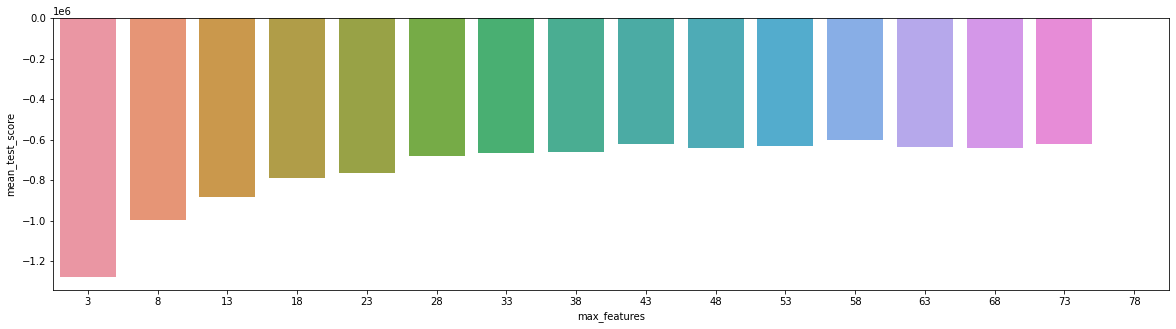

In [158]:
plot_grid_search_cv_results(search_4_clf, distributions)

We won't use this hyper-parameter since there is not a significant improvement.

We will hyper-tune subsample.

In [159]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42, max_features=58)

distributions = { "subsample": [0.6, 0.7, 0.75, 0.8, 0.85, 0.9] }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_5_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


({'subsample': 0.8}, -651226.4752937529)

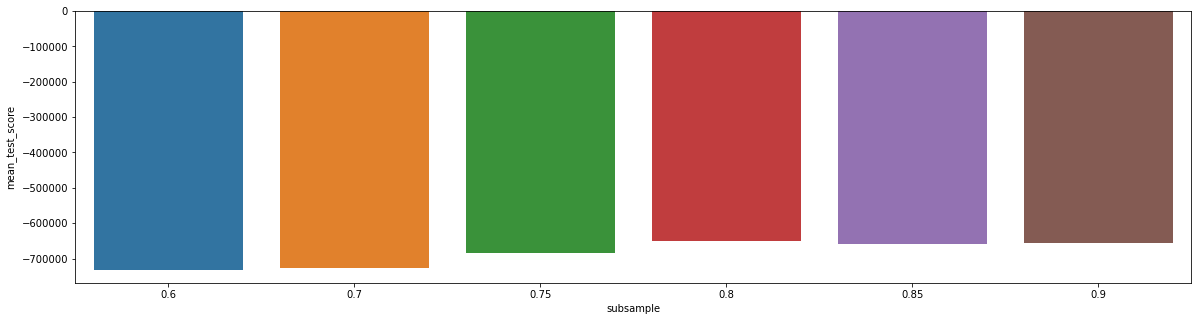

In [160]:
plot_grid_search_cv_results(search_5_clf, distributions)

### Evaluation

#### Baseline model

MSE: 271874806716.87653
RMSE: 521416.1550209933
Explained variance - uniform_average (higher is better): 0.9920410552103963
Explained variance - variance_weighted (higher is better): 0.9920410552103963




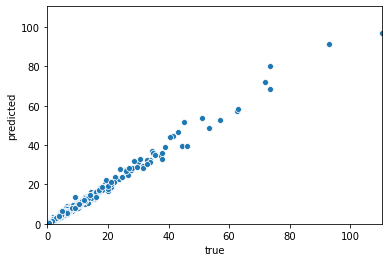

In [145]:
gbr_baseline = GradientBoostingRegressor(random_state=42)

gbr_baseline.fit(X_train, y_train)

custom_regression_report(clf, X_test, y_test)

#### The new model based on hyperparameter search

MSE: 344572331593.8911
RMSE: 587002.8378073578
Explained variance - uniform_average (higher is better): 0.9899151593081326
Explained variance - variance_weighted (higher is better): 0.9899151593081326




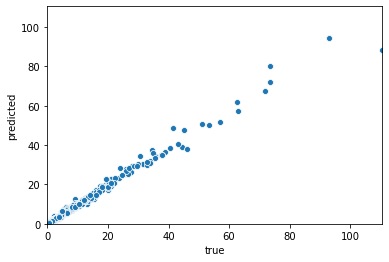

In [161]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

The new model is a little bit worse...

Doing hyper-parameter tunning in steps did not result in a good solution.

We will do hyper-parameter search in one run.

In [162]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, min_samples_split=13, random_state=42)

distributions = { 
    "max_depth": range(1, 10, 2),
    "min_samples_split": range(2, 50, 8),
    "min_samples_leaf": range(1, 20, 4)
}

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 101.8min finished


({'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 42},
 -620656.5336109585)

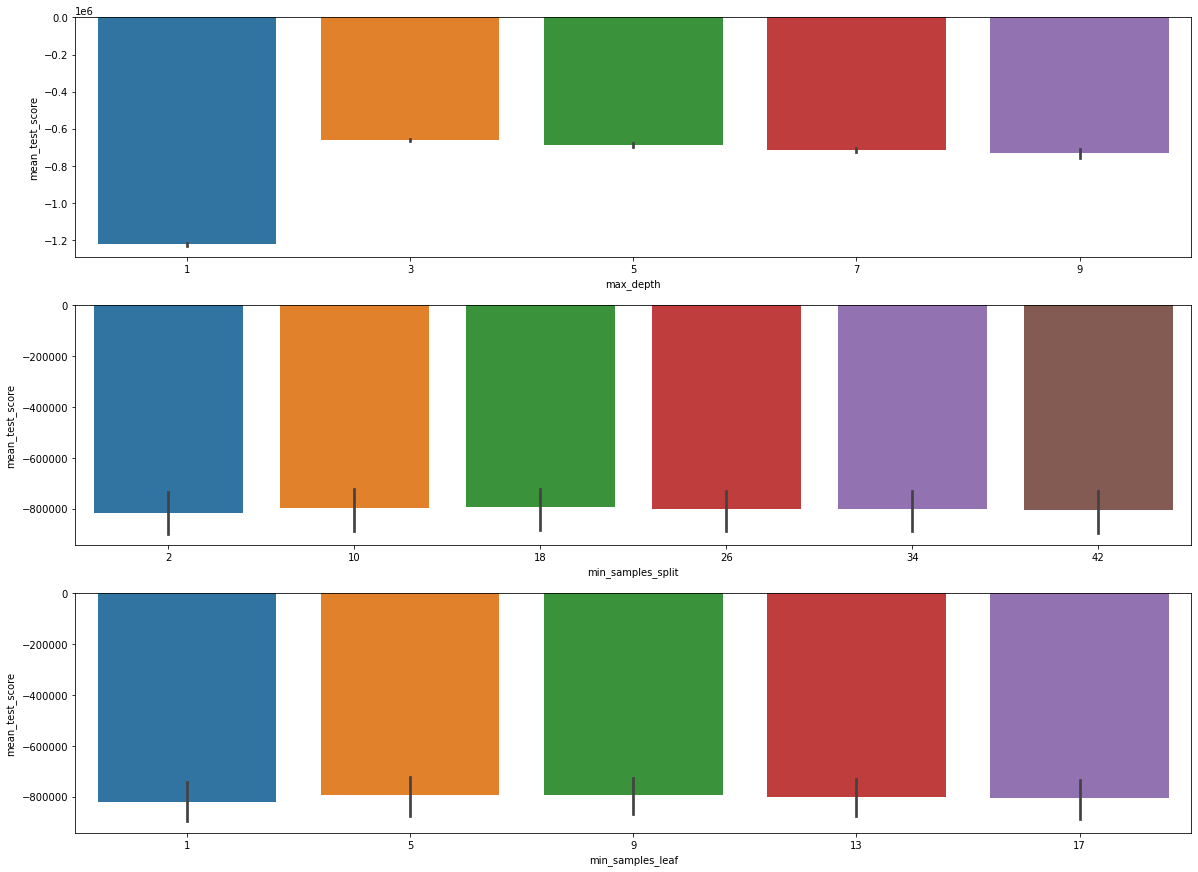

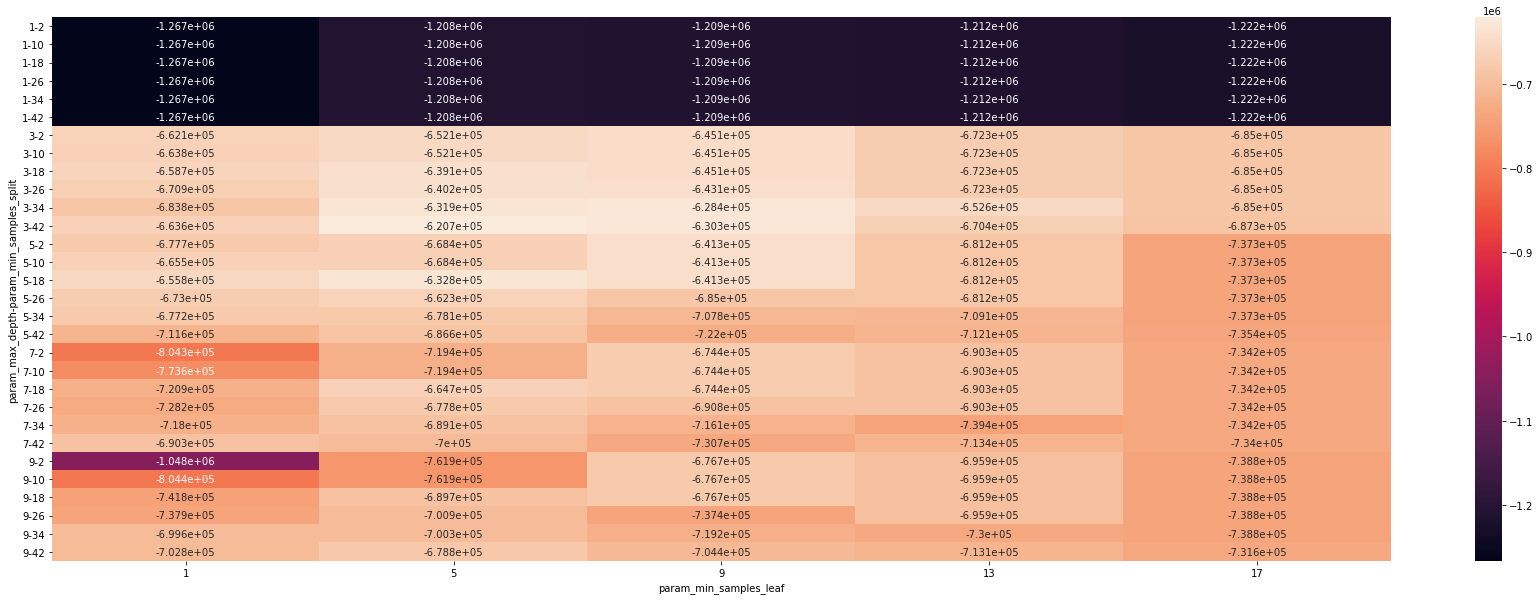

In [166]:
plot_grid_search_cv_results(search_clf, distributions)
plot_grid_search_cv_results(search_clf, distributions, heatmap=True, figsize=(30, 10))

We will try the model based on this.

MSE: 344572331593.8911
RMSE: 587002.8378073578
Explained variance - uniform_average (higher is better): 0.9899151593081326
Explained variance - variance_weighted (higher is better): 0.9899151593081326




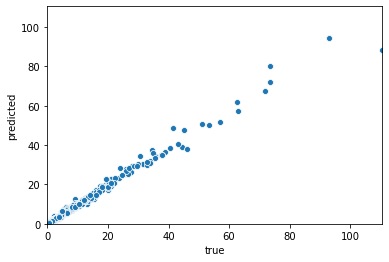

In [176]:
gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=42, min_samples_leaf=5, n_estimators=200, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

The model is worse again. We achieved a better model when we tried to change the params manually (we used the knowledge from the previous results).

MSE: 256339401143.6518
RMSE: 506299.71473787323
Explained variance - uniform_average (higher is better): 0.9925001986544478
Explained variance - variance_weighted (higher is better): 0.9925001986544478




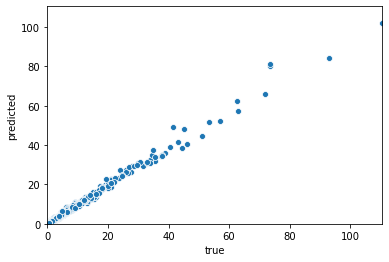

In [175]:
gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=13, n_estimators=200, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

We will try to train the model with as few features possible, based on our previous research in notebook (`10_feature_selection.ipynb`).

Used features - 40
MSE: 265760153067.89893
RMSE: 515519.3042630886
Explained variance - uniform_average (higher is better): 0.9922236114703372
Explained variance - variance_weighted (higher is better): 0.9922236114703372




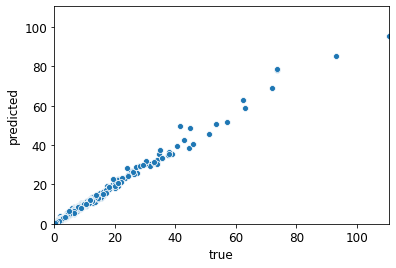

In [72]:
features = ['Contract Length', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Age', 'Overall', 'Potential', 'Height', 'Weight']

print(f'Used features - {len(features)}')

gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=13, n_estimators=200, random_state=42)

gbr.fit(X_train[features], y_train)

custom_regression_report(gbr, X_test[features], y_test)

Used features - 33
MSE: 225300283546.8869
RMSE: 474658.0701377434
Explained variance - uniform_average (higher is better): 0.9934047679511637
Explained variance - variance_weighted (higher is better): 0.9934047679511637




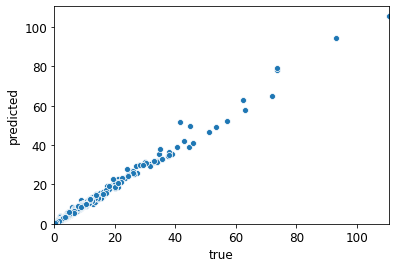

In [74]:
features = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Age', 'Overall', 'Potential', 'Weight']

print(f'Used features - {len(features)}')

gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=13, n_estimators=200, random_state=42)

gbr.fit(X_train[features], y_train)

custom_regression_report(gbr, X_test[features], y_test)

Used features - 2
MSE: 1018195539192.0525
RMSE: 1009056.7571708008
Explained variance - uniform_average (higher is better): 0.970184230268027
Explained variance - variance_weighted (higher is better): 0.970184230268027




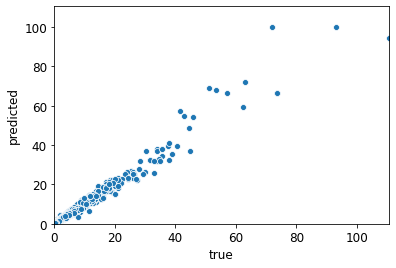

In [100]:
features = ['Age', 'Overall']

print(f'Used features - {len(features)}')

gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=13, n_estimators=200, random_state=42)

gbr.fit(X_train[features], y_train)

custom_regression_report(gbr, X_test[features], y_test)

The final modal can predict the value of the player with error of 500K.

### Conclusion

We were able to train a model with RMSE: 506299.71. What is a significant improvement with our first model in `06_model_selection_regression.ipynb`.